In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import datetime as dt 
import seaborn as sns
from scipy.stats import zscore
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')
import itertools


C:\Users\SONY\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:

# Define the universe of stocks
universe =["HDFCBANK.NS", "RELIANCE.NS","INFY.NS",  "ICICIBANK.NS","TCS.NS","KOTAKBANK.NS","BHARTIARTL.NS",
          "SBIN.NS","HINDUNILVR.NS", "BAJAJFINSV.NS","AXISBANK.NS", "LT.NS", "MARUTI.NS", "NESTLEIND.NS",
          "ASIANPAINT.NS","M&M.NS", "ULTRACEMCO.NS",  "SUNPHARMA.NS","BAJFINANCE.NS","ADANIPORTS.NS", "DRREDDY.NS", 
           "DIVISLAB.NS", "HCLTECH.NS", "NTPC.NS", "ONGC.NS", "TATAMOTORS.NS",
          "TATASTEEL.NS", "WIPRO.NS", "BPCL.NS"]

In [4]:
end = dt.date.today()
start = end - pd.Timedelta(days= 252*10)
end
start

datetime.date(2023, 11, 14)

datetime.date(2016, 12, 20)

In [5]:
class stat_arbit():
    
    def __init__(self,ticker_list, start_date, end_date, interval,sl, tp):
        self.ticker_list = ticker_list
        self.start_date = start_date
        self.end_date = end_date
        self.interval= interval
        self.sl_price= sl
        self.tp_price = tp
        self.data_gathering()
        self.spread_cal()
        self.zscore()
        self.bollinger_bands()
        self.signal_calc()
        self.status()
        self.positions()
        self.trader_price()
        self.returns()
        self.cum_returns()
        self.plot()
        self.performance_analysis()
    
    def data_gathering(self):
        self.data = yf.download(self.ticker_list, self.start_date, self.end_date, self.interval)['Adj Close'].dropna()
        
    def spread_cal(self):
        model = sm.OLS(self.data[self.ticker_list[0]], self.data[self.ticker_list[1]])
        model = model.fit()
        hedge_ratio = model.params[0]
        self.data['spread'] = self.data[self.ticker_list[0]] - model.params[0] * self.data[self.ticker_list[1]]
        return hedge_ratio
    
    def zscore(self):
        self.zscore = zscore(self.data['spread'])
        self.data['zscore'] = self.zscore
    
    def bollinger_bands(self):
        self.data['mean'] = self.data['spread'].rolling(window=20).mean()
        self.data['sd'] = self.data['spread'].rolling(window=20).std()
        self.data['upper_band'] = self.data['mean'] + (2 * self.data['sd'])
        self.data['lower_band'] = self.data['mean'] - (2 * self.data['sd'])
        return self.data.dropna(inplace=True)
    
    def signal_calc(self):
        self.signal =[]
        for i in range(len(self.data)):
            if (self.data.iloc[(i-1), 2] < self.data.iloc[(i-1), 6]) & (self.data.iloc[(i-1),3] < 0)  :
                self.signal.append(1)
            elif (self.data.iloc[(i-1), 2] > self.data.iloc[(i-1), 5]) & (self.data.iloc[(i-1),3] > -2):
                self.signal.append(-1)
            else:
                self.signal.append(0)
        
        self.data['signal'] = self.signal
        signal = pd.Series(self.signal)
        return self.data
    
    def status(self):
        self.status = [0]
        for i in range(1, len(self.data)):
            if (self.status[i-1] == 0) | (self.status[i-1]== 'TP') | (self.status[i-1]=='SL'):
                self.status.append(self.signal[i-1])
            else:
                spread = self.data.iloc[i, 2]
                sl_price = spread * self.sl_price
                tp_price = spread * self.tp_price
                
                if (self.status[i-1] == 1 and spread <= sl_price) or (self.status[i-1] == -1 and spread >= sl_price):
                    self.status.append('SL')
                elif (self.status[i-1] == 1 and spread >= tp_price) or (self.status[i-1] == -1 and spread <= tp_price):
                    self.status.append('TP')
                else:
                    self.status.append(self.status[i-1])

        self.data['status'] = self.status
        return self.data
    
    def positions(self):
        self.data['pair1'] = 0
        self.data['pair2'] = 0

        for i in range(1, len(self.data)):
            if self.status[i-1] == 0:
                self.data['pair1'].iloc[i] = 0
                self.data['pair2'].iloc[i] = 0
            elif self.status[i-1] == 'SL' or self.status[i-1] == 'TP':
                self.data['pair1'].iloc[i] = 0
                self.data['pair2'].iloc[i] = 0
            elif self.signal[i-1] == 1:
                self.data['pair1'].iloc[i] = 1
                self.data['pair2'].iloc[i] = -1
            elif self.signal[i-1] == -1:
                self.data['pair1'].iloc[i] = -1
                self.data['pair2'].iloc[i] = 1

        return self.data[['pair1', 'pair2']]
      
    def trader_price(self):
        self.tp_stock1 = [0]
        self.tp_stock2 = [0]

        for i in range(1, len(self.data['status'])):
            if self.data['status'][i-1] == -1:
                # Sell pair2[i] and buy pair1[i]
                sell_pair2 = self.data.iloc[i-1,0]
                buy_pair1 = self.data.iloc[i-1,1]
                
                self.tp_stock1.append(buy_pair1)
                self.tp_stock2.append(sell_pair2)
            
            elif self.data['status'][i-1]== 1:
                # Buy pair1[i] and sell pair2[i]
                sell_pair2 = self.data.iloc[i-1,0]
                buy_pair1 = self.data.iloc[i-1,1]
                 
                self.tp_stock1.append(buy_pair1)
                self.tp_stock2.append(sell_pair2)
            
            else:
                self.tp_stock1.append(np.nan)
                self.tp_stock2.append(np.nan)
            
        self.data['stock1_tp'] = self.tp_stock1
        self.data['stock2_tp'] = self.tp_stock2
    
        self.data['stock1_tp'] = self.data['stock1_tp'].ffill()
        self.data['stock2_tp'] = self.data['stock2_tp'].ffill()
    
        self.data['stock1_tp'] = self.data['stock1_tp'].shift(-1)
        self.data['stock2_tp'] = self.data['stock2_tp'].shift(-1)
        
    def returns(self):
        stock1_returns = [0]*len(self.data)
        stock2_returns=  [0]*len(self.data)
   
        for i in range(1, len(self.data['status'])):
            if self.data['pair1'][i-1] == 1:
                # Calculate the returns for stock1
                s1returns = self.data.iloc[(i),12] / self.data.iloc[(i-1),12] - 1
                stock1_returns[i] = s1returns
            
            elif self.data['pair1'][i-1] == -1:
                # Calculate the returns for stock2
                s1returns = 1- (self.data.iloc[(i),12] / self.data.iloc[(i-1),12]) 
                stock1_returns[i] = s1returns

            if self.data['pair2'][i-1] == 1:
                # Calculate the returns for stock1
                s2returns = self.data.iloc[(i),13] / self.data.iloc[(i-1),13] - 1
                stock2_returns[i] = s2returns

            elif self.data['pair2'][i-1] == -1:
                # Calculate the returns for stock2
                s2returns = 1 - (self.data.iloc[(i),13] / self.data.iloc[(i-1),13]) 
                stock2_returns[i] = s2returns
        
        self.data['stock1_returns'] = stock1_returns
        self.data['stock2_returns'] = stock2_returns
        
        self.data['returns'] = self.data['stock1_returns'] + self.data['stock2_returns']
        self.data['cum_returns'] = (1 + self.data['returns']).cumprod()
        return   
        
    def cum_returns(self):
        self.data['cum_returns'] = (1 + self.data['returns']).cumprod()
        #last_return = self.data['cum_returns'].iloc[-1]

#        if pd.isna(last_return):
 #           last_return = self.data['cum_returns'].iloc[-2]

        return  self.data['cum_returns'] - 1 
    
    #last_return -1 
        
    def plot(self):
        plt.plot(self.data.index, self.data['cum_returns'])
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns (%)')
        plt.title('Cumulative Returns Over Time')
        plt.show()
        
    def performance_analysis(self):
        # Calculate daily returns
        daily_returns = self.data['spread'].pct_change()

        # Calculate mean and standard deviation of daily returns
        mean_daily_return = daily_returns.mean()
        std_daily_return = daily_returns.std()

        # Assume risk-free rate is 1% annualized
        risk_free_rate = 0.01 / 252

        # Calculate Sharpe ratio
        sharpe_ratio = np.sqrt(252) * (mean_daily_return - risk_free_rate) / std_daily_return
        print("sharpe_ratio :", sharpe_ratio)
        
        # Calculate rolling maximum of cumulative returns
        rolling_max = self.data['cum_returns'].cummax()

        # Calculate drawdown from rolling maximum
        drawdown = (self.data['cum_returns'] - rolling_max) / rolling_max

        # Calculate maximum drawdown
        max_drawdown = drawdown.min()
        
        print("max_dd:",max_drawdown*100)


In [6]:
data = yf.download(universe, start, end, interval='1d')['Adj Close'].dropna()
data.head(3)


[*********************100%%**********************]  29 of 29 completed


,ADANIPORTS.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,BPCL.NS,DIVISLAB.NS,DRREDDY.NS,HCLTECH.NS,...,NTPC.NS,ONGC.NS,RELIANCE.NS,SBIN.NS,SUNPHARMA.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,ULTRACEMCO.NS,WIPRO.NS
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-20,261.608917,826.421509,455.432617,268.589844,788.142151,267.994019,277.025208,1077.806519,2867.288574,351.018921,...,100.154457,140.368774,507.243439,241.428299,592.064636,471.679901,31.678852,1014.066711,3064.869141,169.970291
2016-12-21,263.337677,826.278381,451.535828,265.126160,771.319092,267.241089,277.817322,1084.938110,2858.205322,347.065277,...,101.268326,141.527664,509.808685,242.187057,579.382202,467.044373,31.757364,1002.926086,3110.419678,168.440506
2016-12-22,253.109512,830.812805,441.522522,254.181778,748.627625,258.870453,276.436798,1046.824341,2835.147217,345.500763,...,99.319084,136.892014,505.061798,236.923157,574.384766,468.140961,30.791683,1000.368347,3063.017822,168.167328


In [7]:

# ## Possible_pairs

possible_pairs = []
for i in range(len(universe)):
    for j in range(i+1, len(universe)):
        possible_pairs.append((universe[i], universe[j]))
print(len(possible_pairs))


406


In [8]:

# ## Find the cointegration between the pairs 

class stationarity_check():
    
    def __init__(self, ticker_list, start, end, interval):
        self.ticker_list = ticker_list
        self.start = start
        self.end = end
        self.interval = interval
        self.data()
        self.cointegration_test()
        
    def data(self):
        self.data= yf.download(self.ticker_list, self.start,self.end,self.interval)['Adj Close'].dropna()

    def cointegration_test(self):
        model = sm.OLS(self.data[self.ticker_list[0]], self.data[self.ticker_list[1]])
        model = model.fit()
        hedge_ratio = model.params[0]
        self.data['spread'] = self.data[self.ticker_list[0]] - model.params[0] * self.data[self.ticker_list[1]]
        adf = adfuller(self.data['spread'], maxlag = 1)
        test_stat = adf[0] 
        t_stat = adf[4]['5%']
        if test_stat < t_stat:
            return True 
        else: 
            return False


In [9]:
# ## strategy implementation 
# Find cointegrated pairs
cointegrated_pairs = []
for pair in possible_pairs:
    sc = stationarity_check(pair, start, end, interval='1d')
    if sc.cointegration_test() is not False:
        cointegrated_pairs.append(pair)

print(len(cointegrated_pairs))

[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%*******

[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%*******

[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%*******

[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%*******

In [10]:

# correlation of the pairs

class correlation():
    
    def __init__(self, ticker_list, start, end, interval):
        self.ticker_list = ticker_list
        self.start = start
        self.end = end
        self.interval = interval
        self.data()
        self.correlation_test()
        
    def data(self):
        self.data= yf.download(self.ticker_list, self.start,self.end,self.interval)['Adj Close'].dropna()

    def correlation_test(self):
        correlation = self.data[self.ticker_list[0]].corr(self.data[self.ticker_list[1]])
        if correlation > 0.5:
            return True
        else:
            return False  

In [11]:
# correlation test
    
correlation_pairs = []
for pair in cointegrated_pairs:
    corr = correlation(pair, start, end, interval='1d')
    if corr.correlation_test() is not False:
        correlation_pairs.append(pair)

print(len(correlation_pairs))


[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%*******

[*********************100%%**********************]  2 of 2 completed


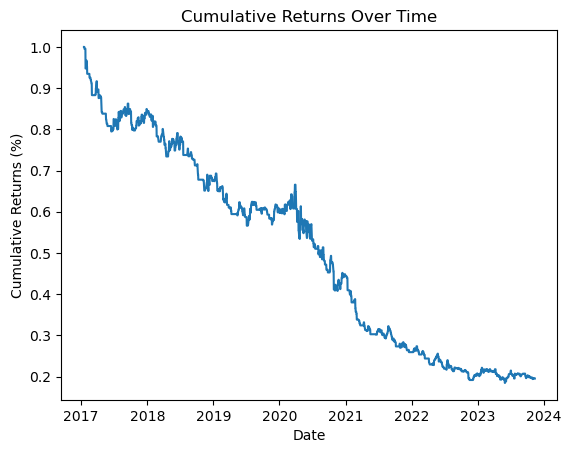

sharpe_ratio : -0.48672059070119533
max_dd: -81.53918018428405


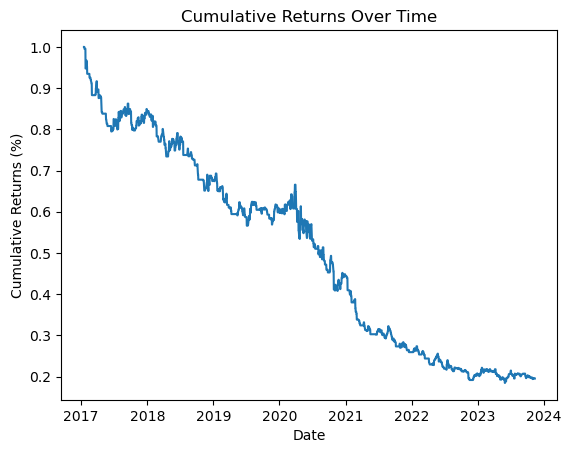

[*********************100%%**********************]  2 of 2 completed


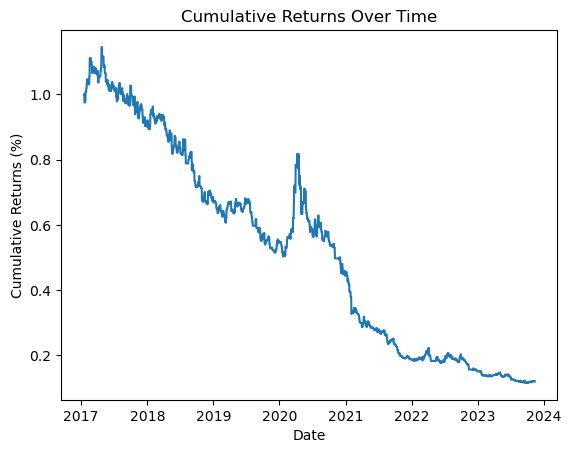

sharpe_ratio : -0.30037430238858204
max_dd: -89.87577125250364


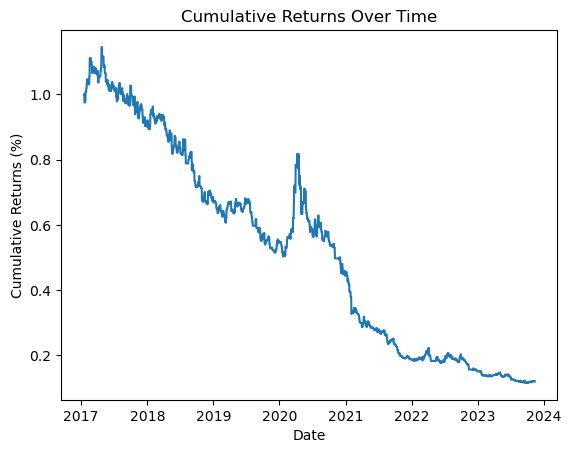

[*********************100%%**********************]  2 of 2 completed


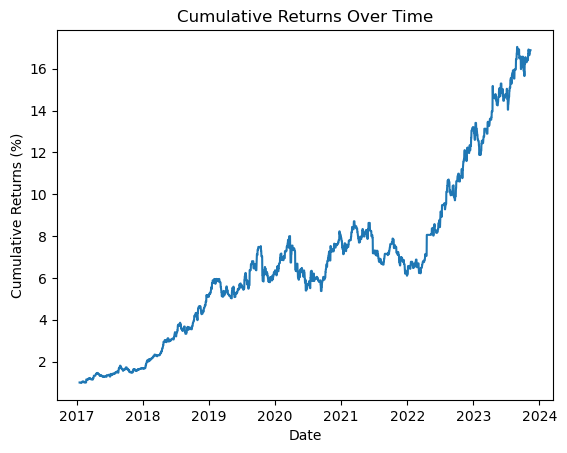

sharpe_ratio : 0.2629820193396677
max_dd: -32.84786982484025


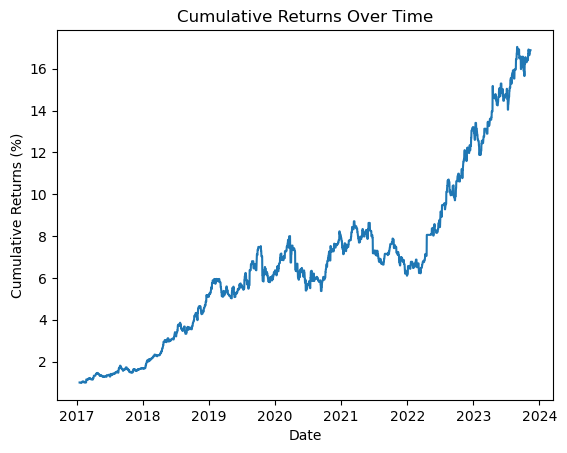

[*********************100%%**********************]  2 of 2 completed


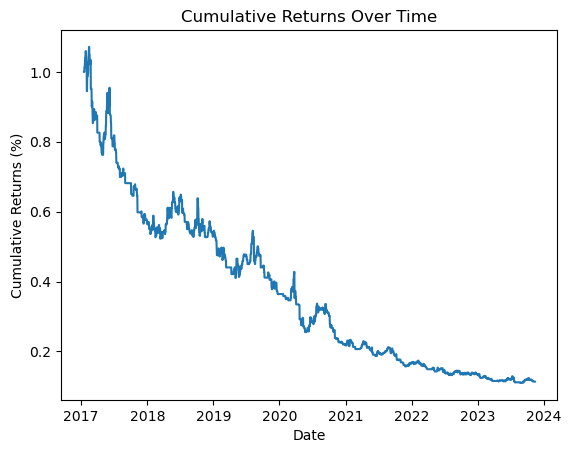

sharpe_ratio : -0.3519823829765581
max_dd: -89.75208188883245


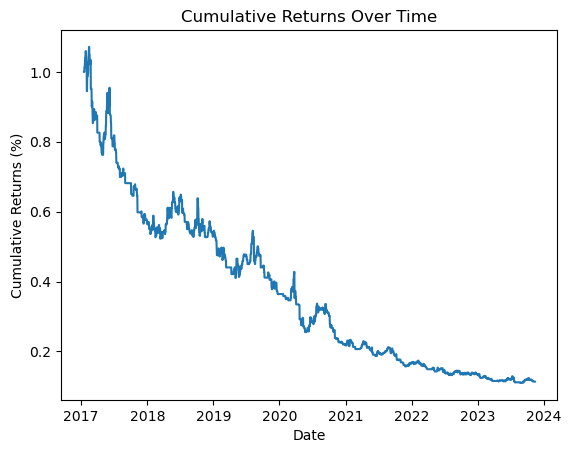

[*********************100%%**********************]  2 of 2 completed


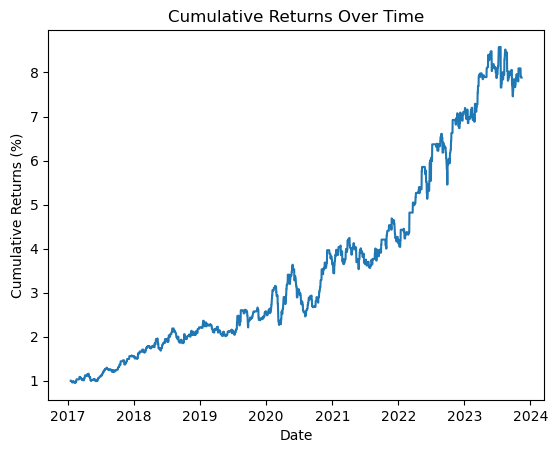

sharpe_ratio : -0.6393149851040272
max_dd: -32.31897394751616


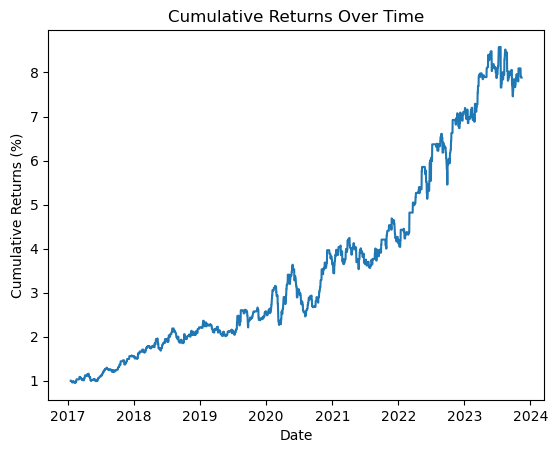

[*********************100%%**********************]  2 of 2 completed


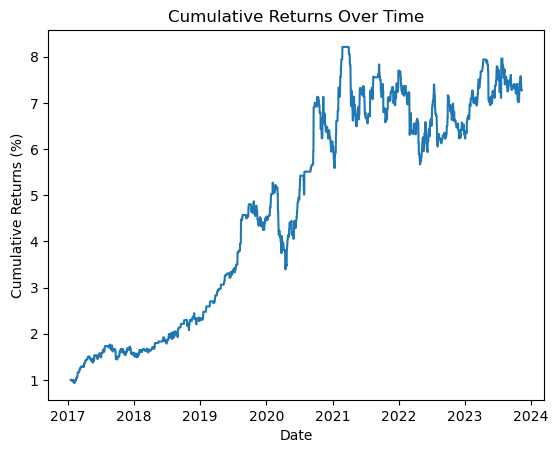

sharpe_ratio : -0.4028514940334686
max_dd: -35.57437580994789


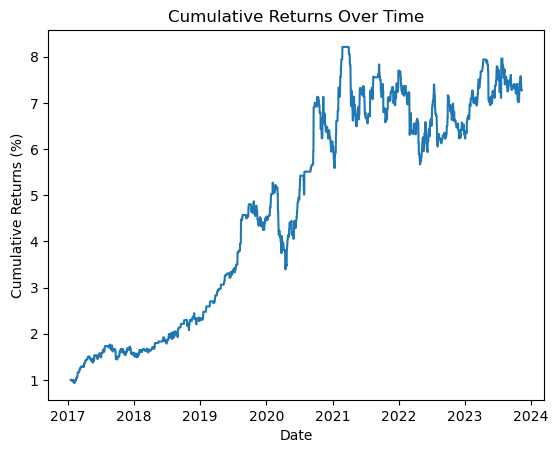

[*********************100%%**********************]  2 of 2 completed


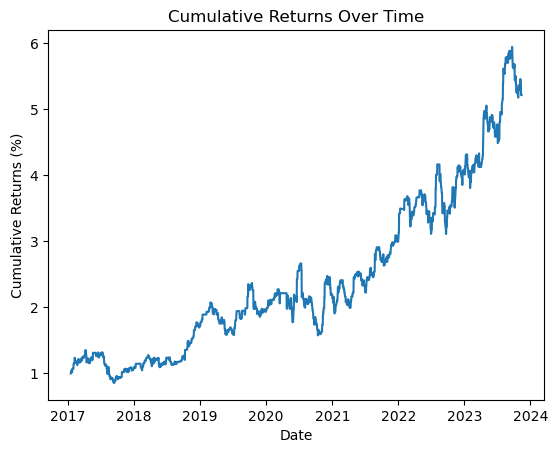

sharpe_ratio : -0.34757348908168184
max_dd: -40.873212053010214


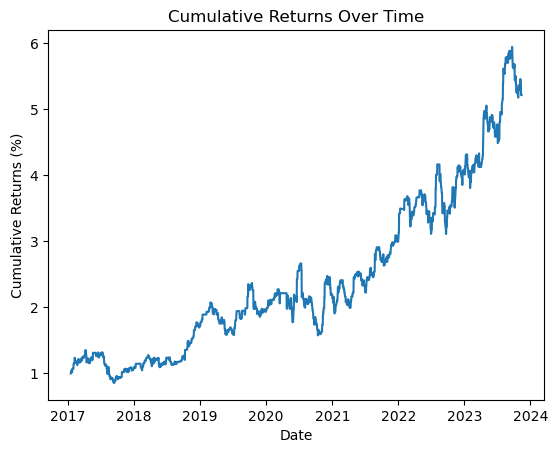

[*********************100%%**********************]  2 of 2 completed


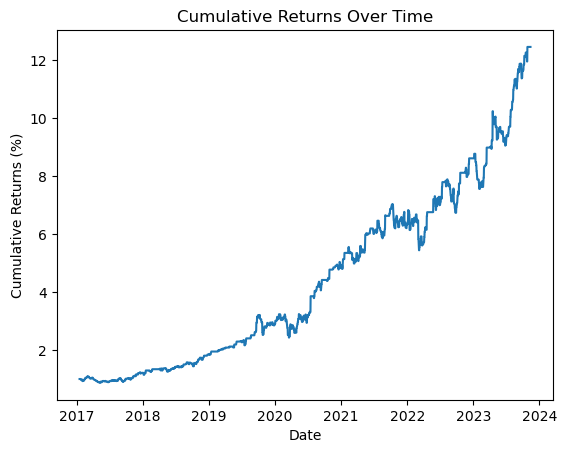

sharpe_ratio : -0.8753603829425767
max_dd: -24.8833508165845


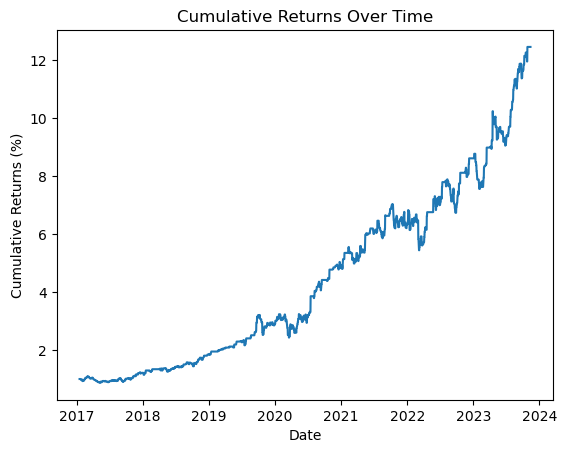

[*********************100%%**********************]  2 of 2 completed


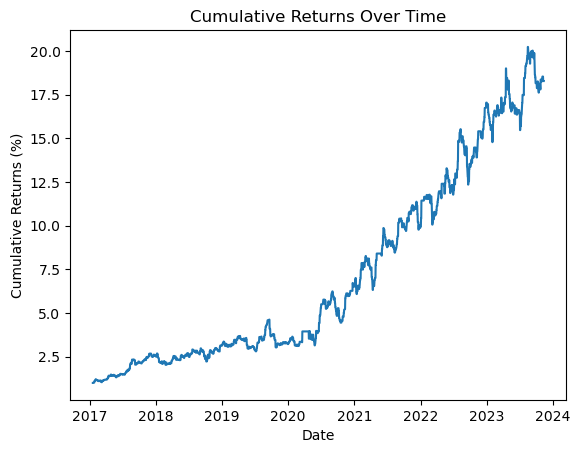

sharpe_ratio : 0.3702737356330703
max_dd: -34.483494268263094


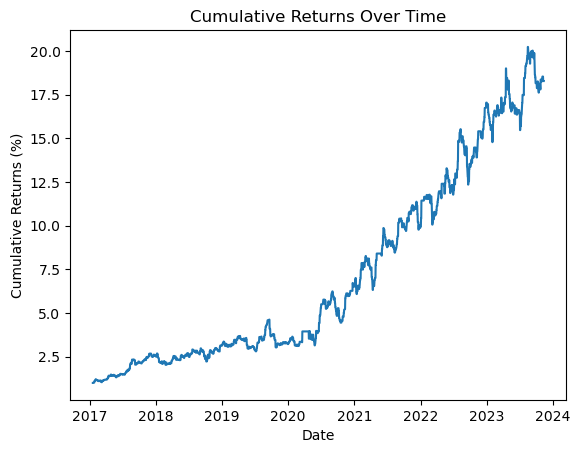

[*********************100%%**********************]  2 of 2 completed


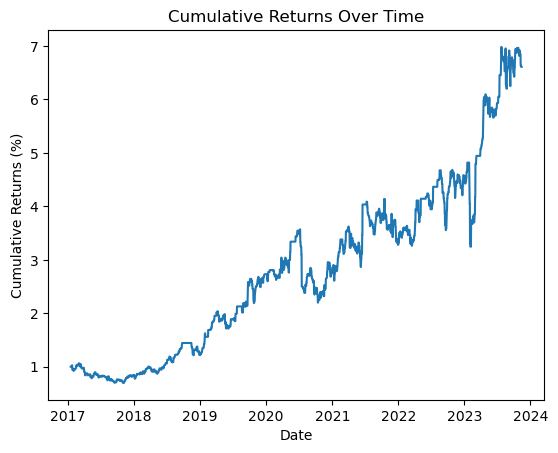

sharpe_ratio : -0.33747118407609666
max_dd: -38.36729407165393


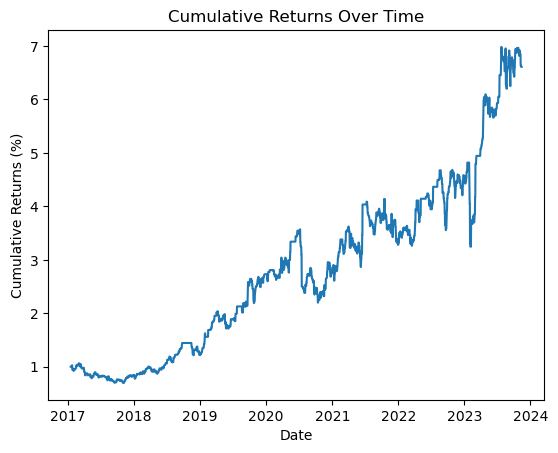

[*********************100%%**********************]  2 of 2 completed


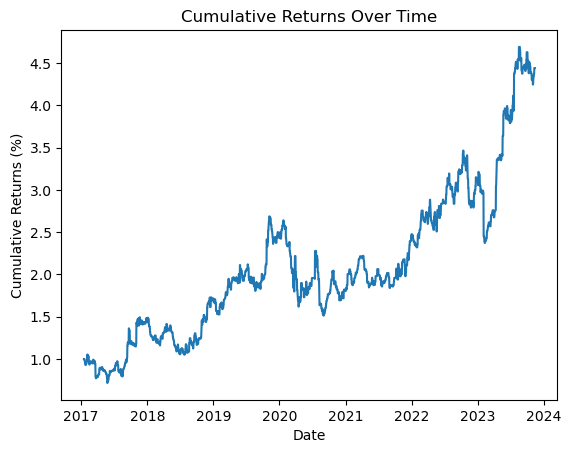

sharpe_ratio : -0.015173960814009574
max_dd: -43.668675983807006


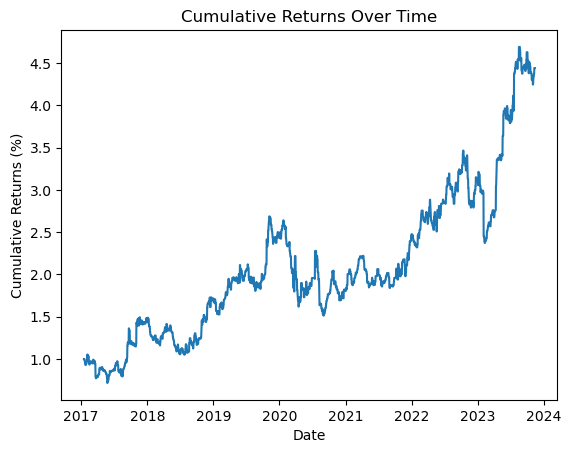

[*********************100%%**********************]  2 of 2 completed


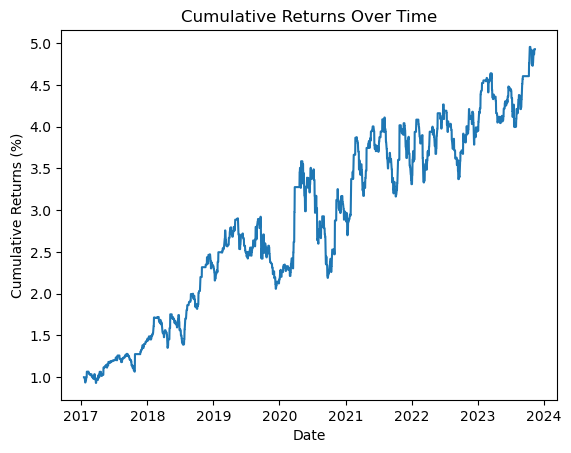

sharpe_ratio : 0.6531139740191565
max_dd: -38.94887973707438


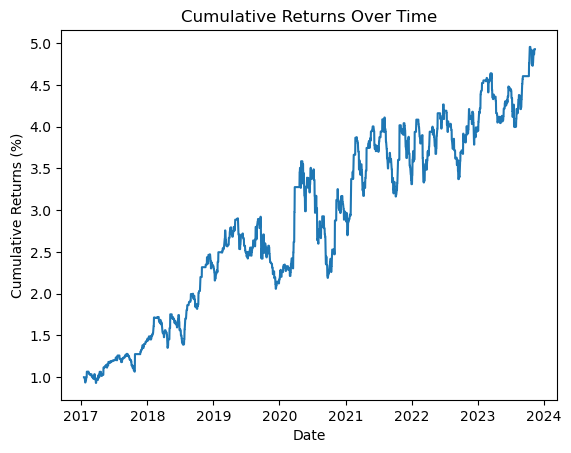

[*********************100%%**********************]  2 of 2 completed


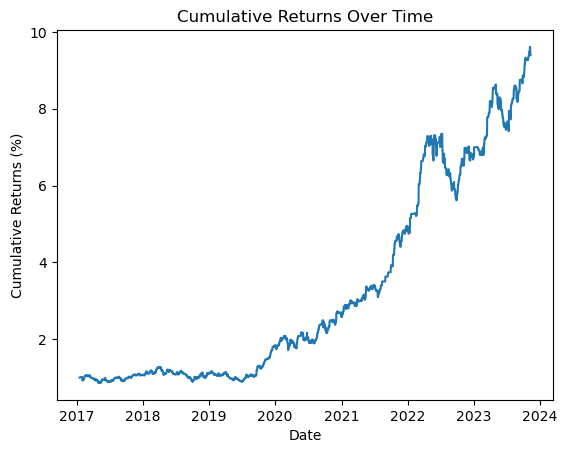

sharpe_ratio : 0.40166621447004747
max_dd: -30.341065339884395


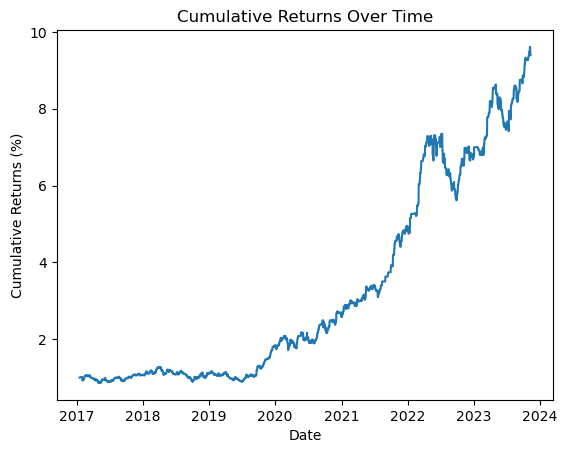

[*********************100%%**********************]  2 of 2 completed


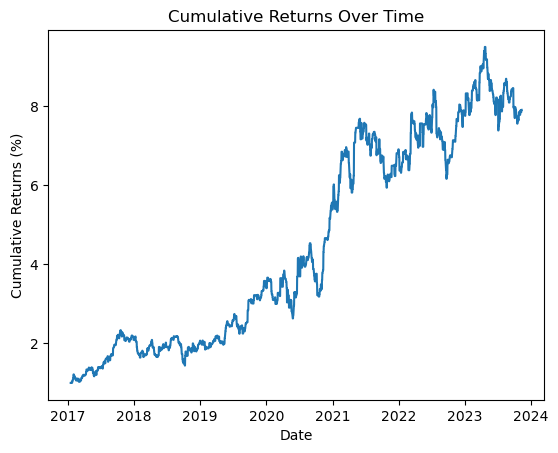

sharpe_ratio : -0.5145165602236723
max_dd: -38.33869534653122


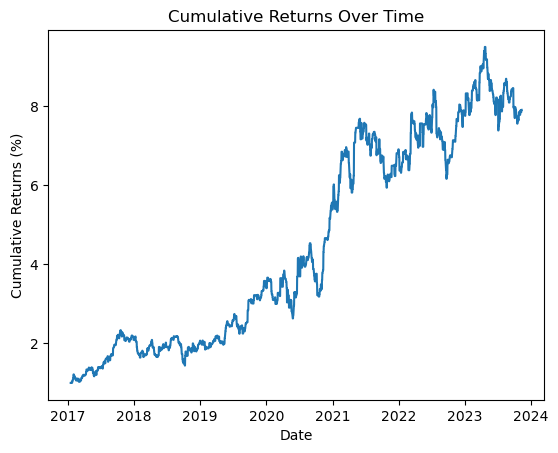

[*********************100%%**********************]  2 of 2 completed


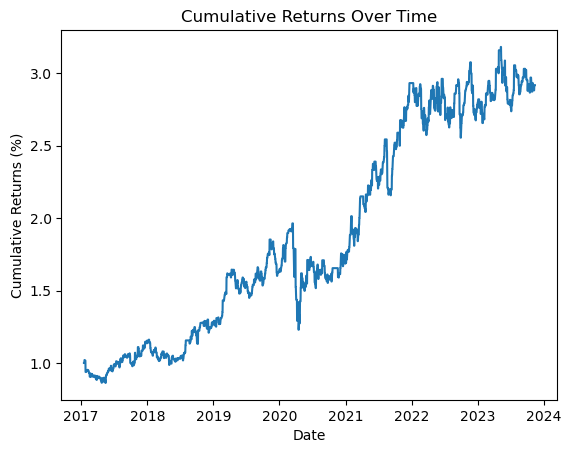

sharpe_ratio : -0.09842722068269444
max_dd: -37.39742607757226


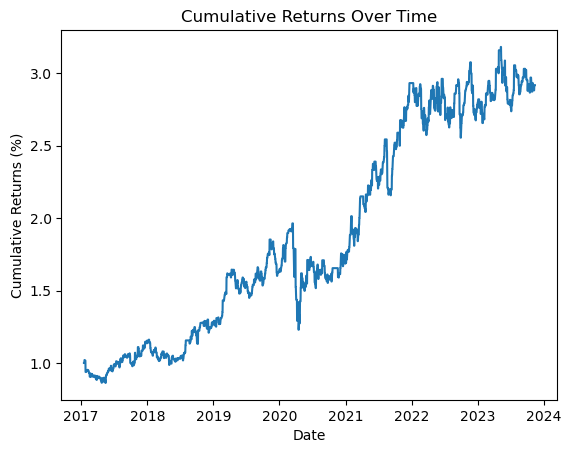

[*********************100%%**********************]  2 of 2 completed


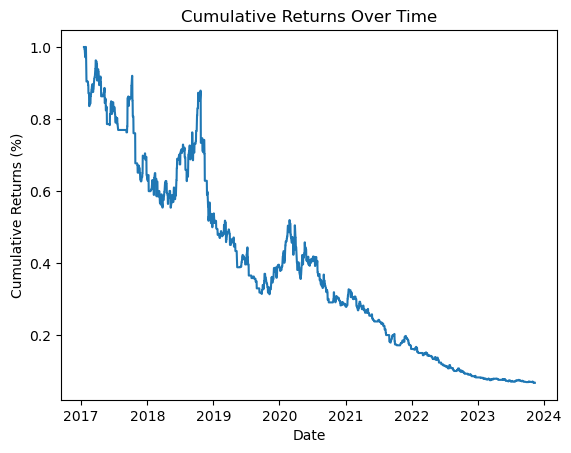

sharpe_ratio : -0.3673949559656023
max_dd: -93.30524168747588


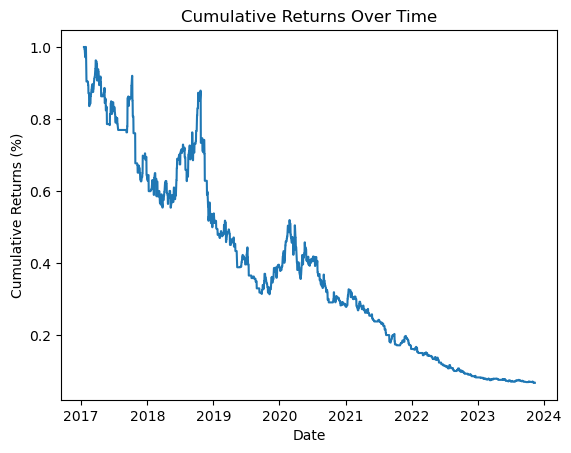

[*********************100%%**********************]  2 of 2 completed


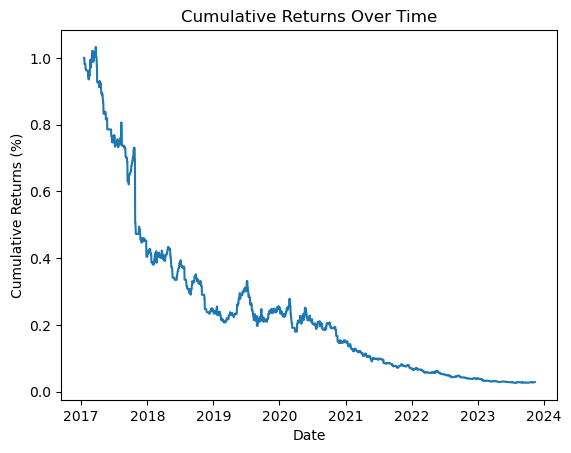

sharpe_ratio : 0.11139863977384067
max_dd: -97.45551483018677


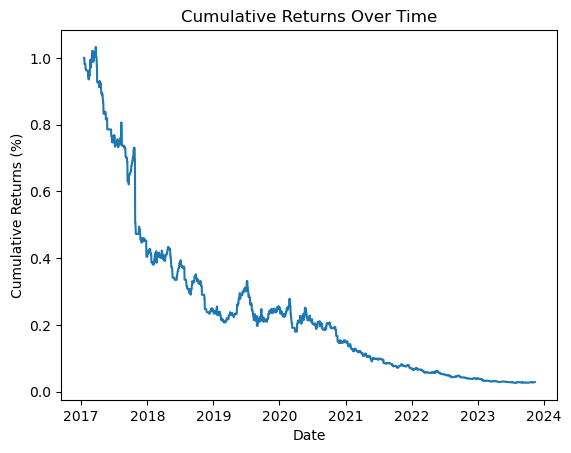

[*********************100%%**********************]  2 of 2 completed


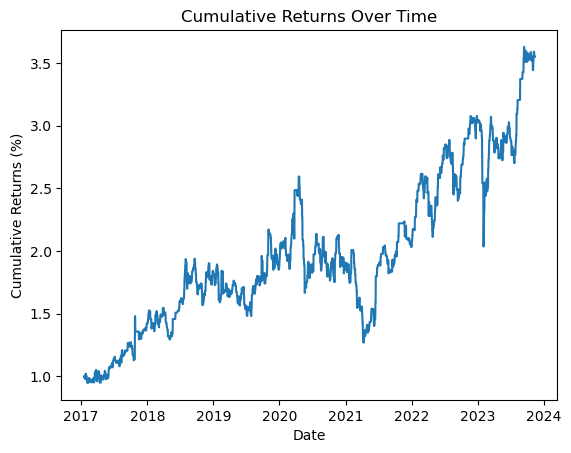

sharpe_ratio : -0.2541687419895767
max_dd: -51.03040511928519


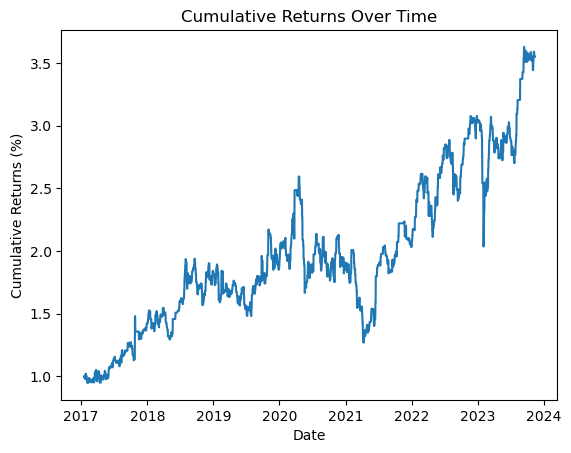

[*********************100%%**********************]  2 of 2 completed


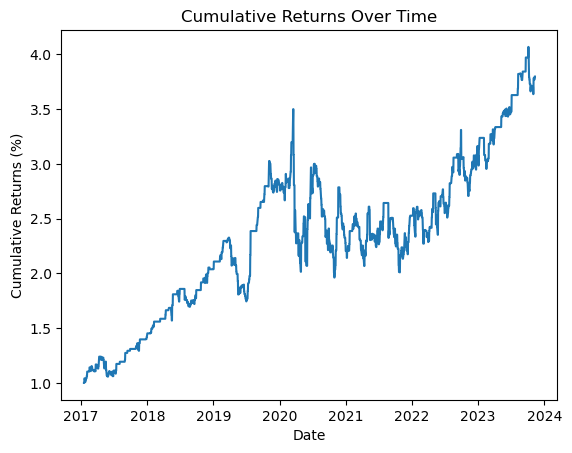

sharpe_ratio : 0.01659278479490575
max_dd: -43.931703587694884


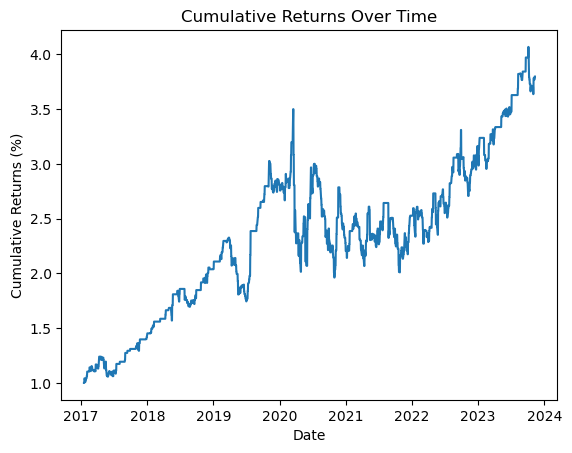

[*********************100%%**********************]  2 of 2 completed


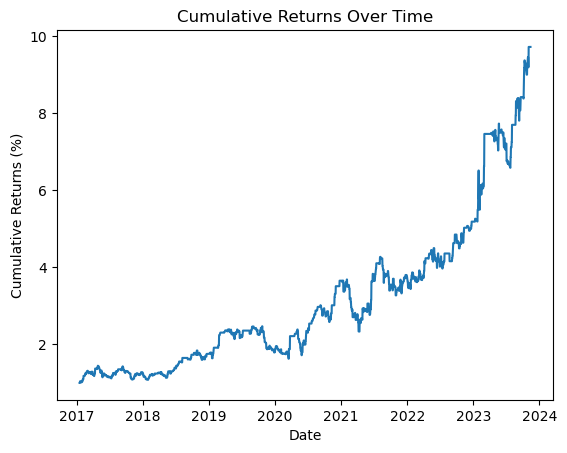

sharpe_ratio : 0.29033230065731996
max_dd: -36.68800640686235


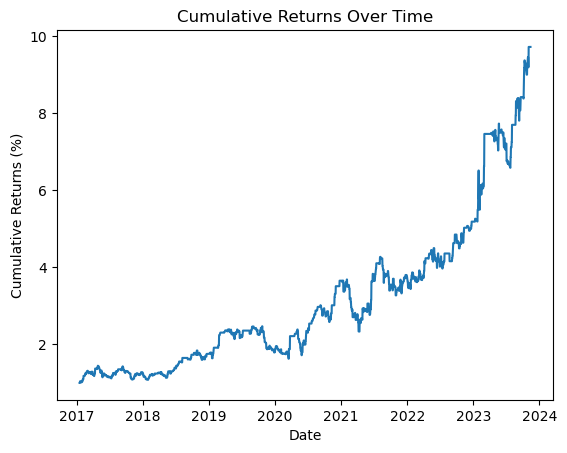

[*********************100%%**********************]  2 of 2 completed


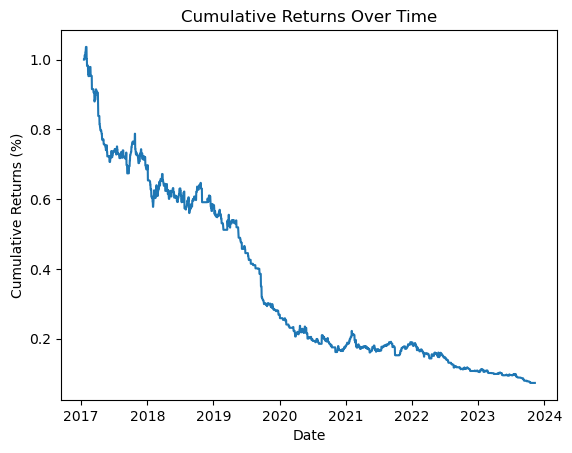

sharpe_ratio : -0.04394703949606197
max_dd: -92.96163552576547


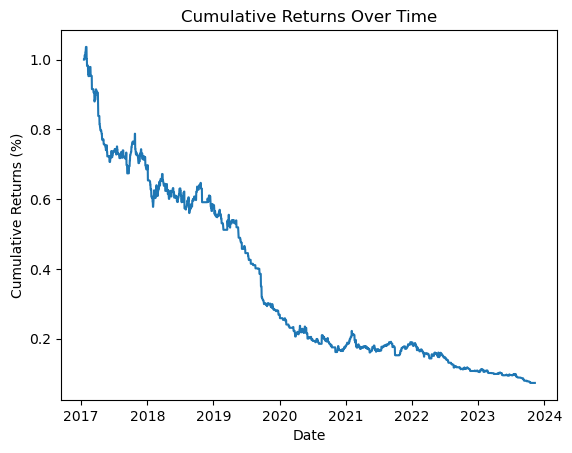

[*********************100%%**********************]  2 of 2 completed


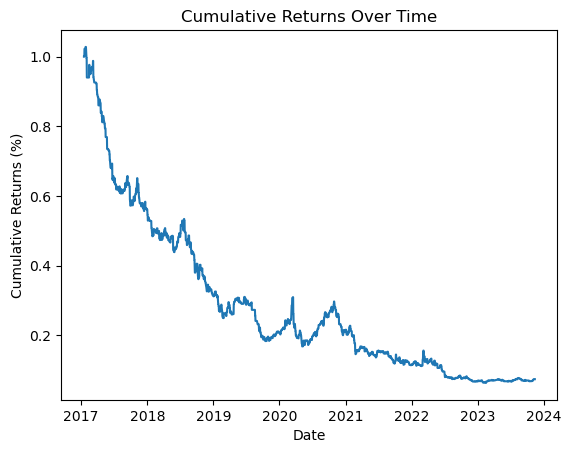

sharpe_ratio : 0.7751727738879195
max_dd: -93.8492392000544


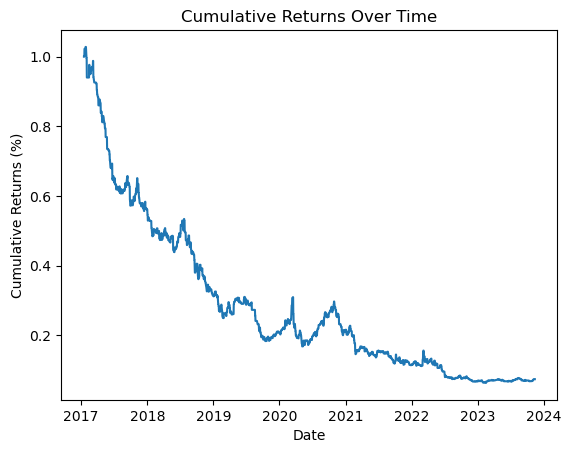

[*********************100%%**********************]  2 of 2 completed


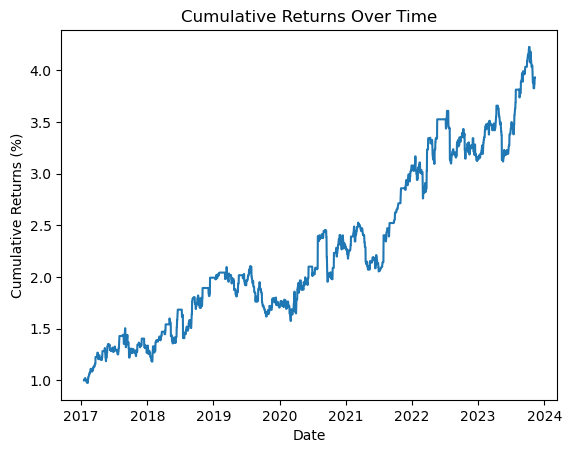

sharpe_ratio : 0.8056063985023151
max_dd: -25.114954205748997


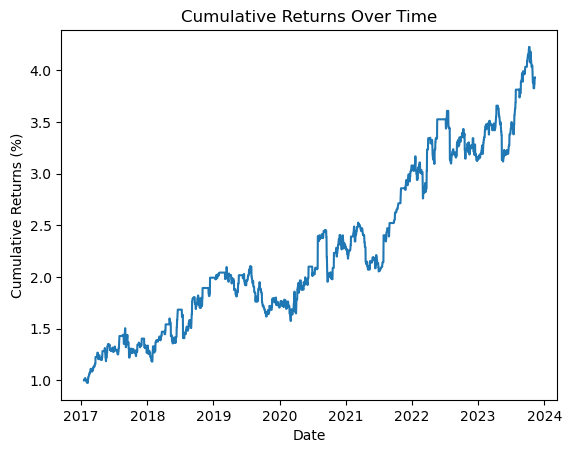

[*********************100%%**********************]  2 of 2 completed


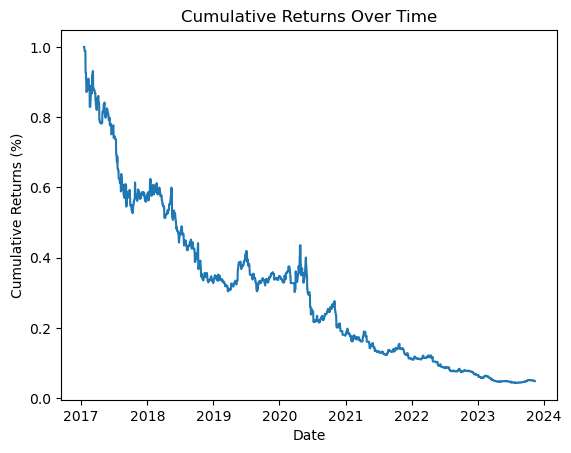

sharpe_ratio : 0.8455390342731555
max_dd: -95.68951299399482


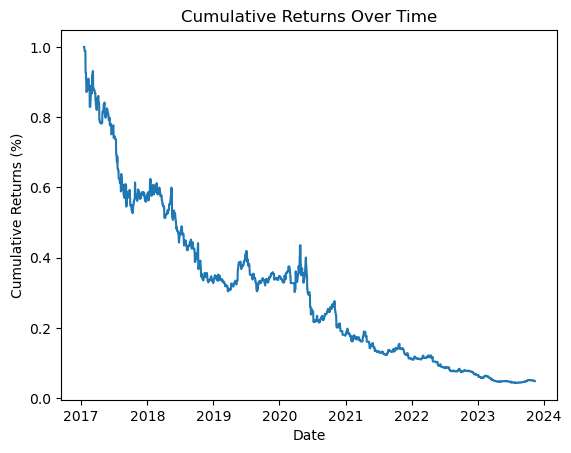

[*********************100%%**********************]  2 of 2 completed


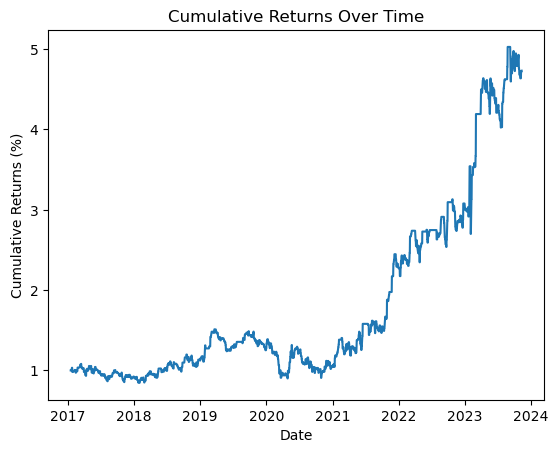

sharpe_ratio : -0.17978340823891173
max_dd: -40.41400085926003


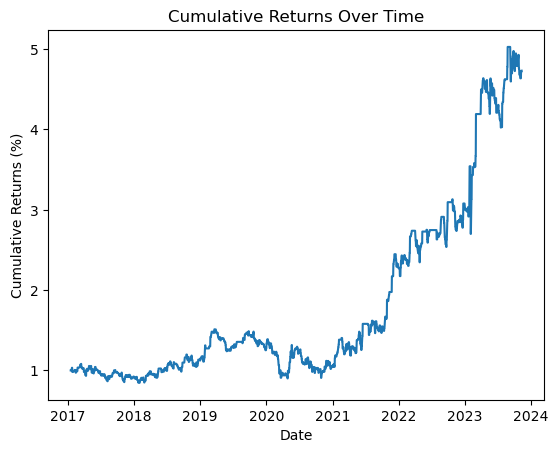

[*********************100%%**********************]  2 of 2 completed


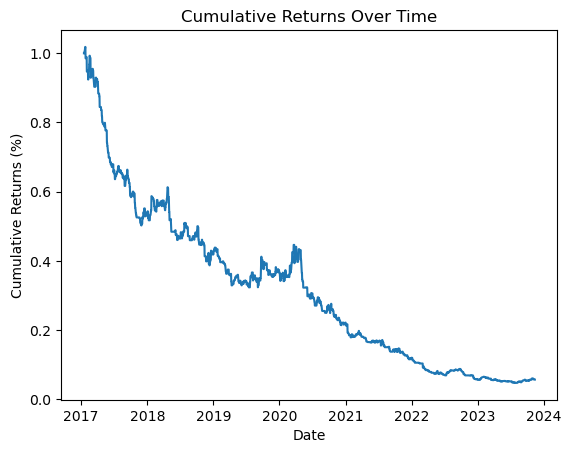

sharpe_ratio : -0.2392621607993487
max_dd: -95.40183196448226


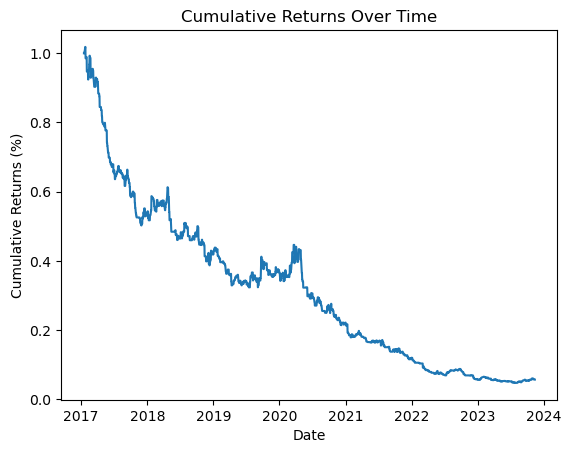

[*********************100%%**********************]  2 of 2 completed


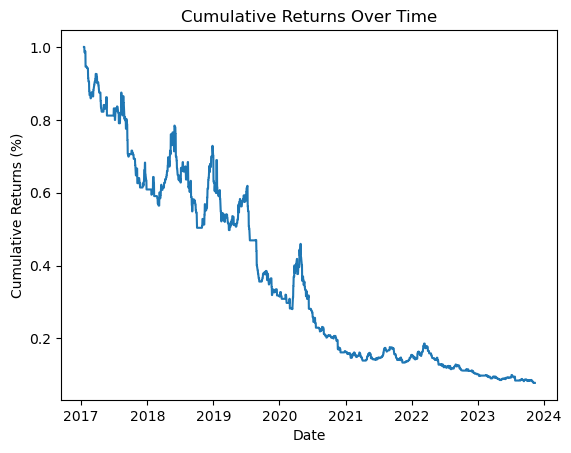

sharpe_ratio : -0.4336252460133389
max_dd: -92.21105548821453


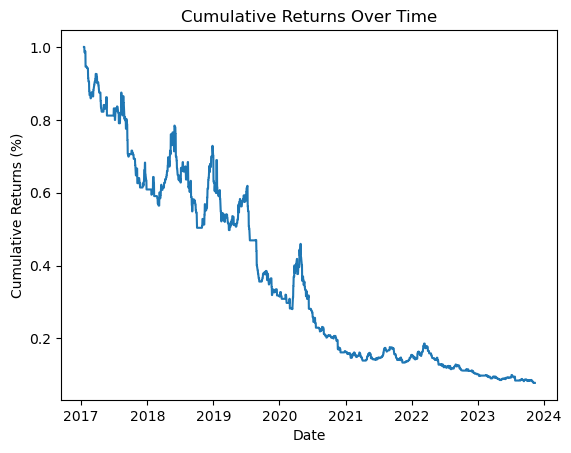

[*********************100%%**********************]  2 of 2 completed


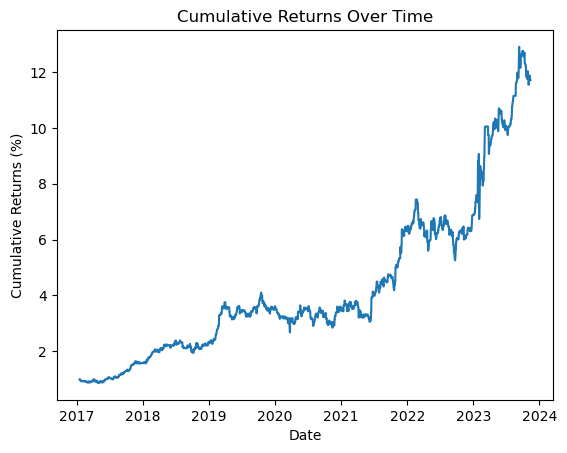

sharpe_ratio : 0.06589232651726551
max_dd: -34.71656025908496


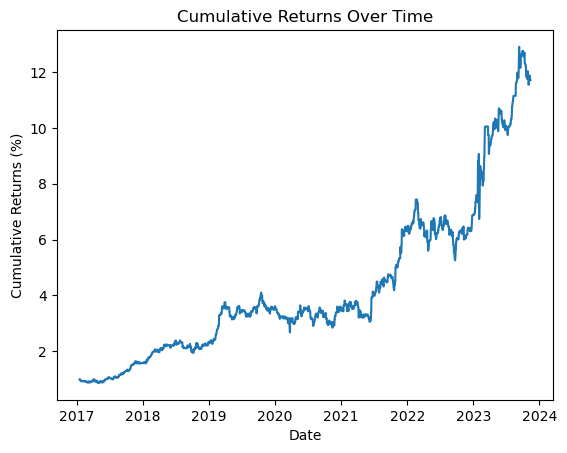

[*********************100%%**********************]  2 of 2 completed


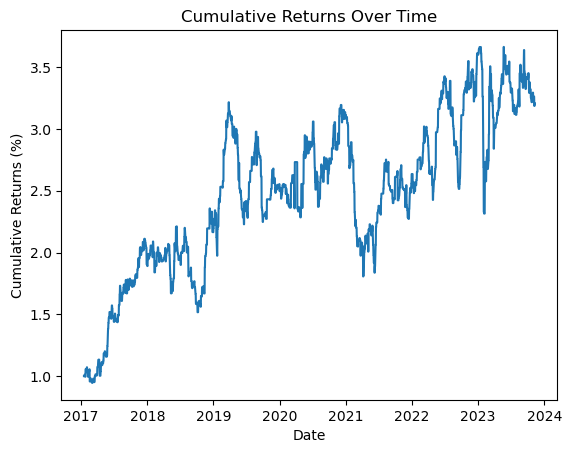

sharpe_ratio : 0.08512262340233506
max_dd: -43.82079267527454


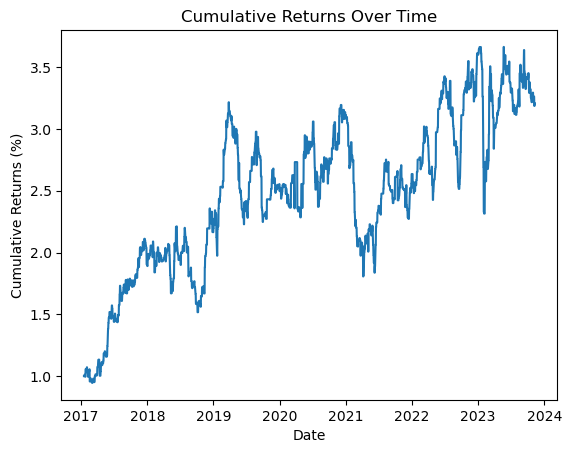

[*********************100%%**********************]  2 of 2 completed


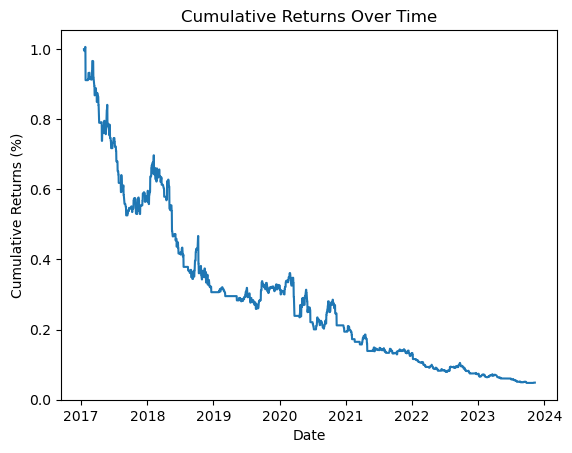

sharpe_ratio : 0.1493495497155652
max_dd: -95.24207413012057


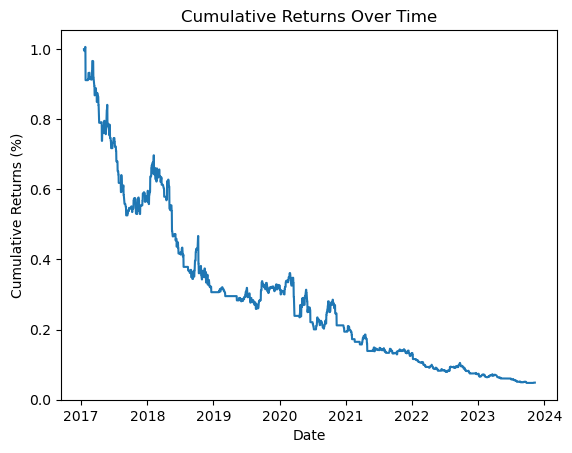

[*********************100%%**********************]  2 of 2 completed


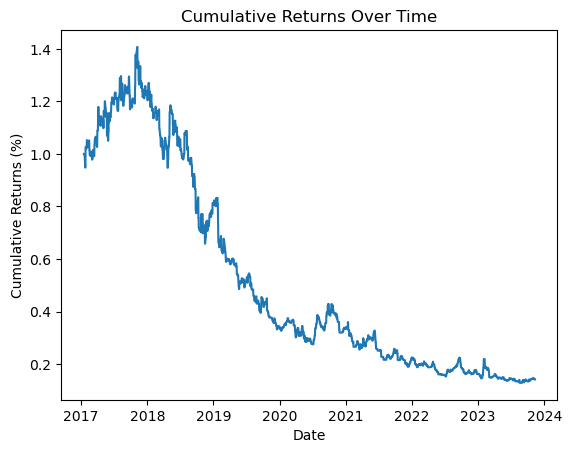

sharpe_ratio : -0.2801311622378149
max_dd: -90.89211732741646


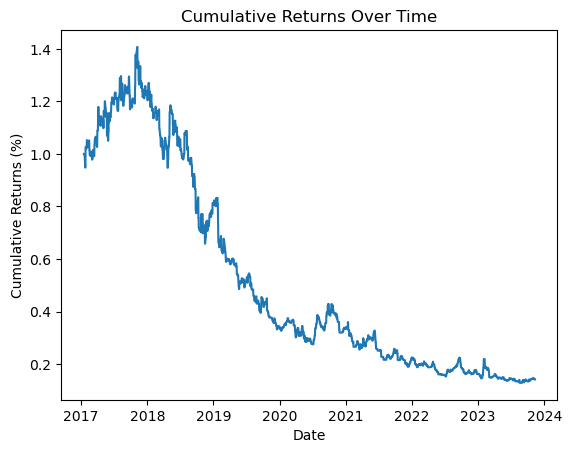

[*********************100%%**********************]  2 of 2 completed


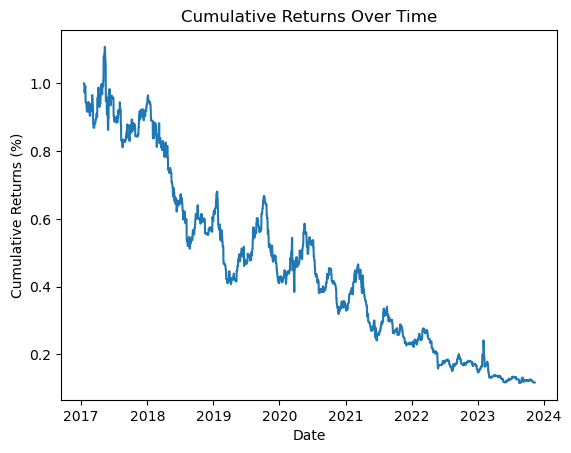

sharpe_ratio : 0.6200763830746874
max_dd: -89.53448872289184


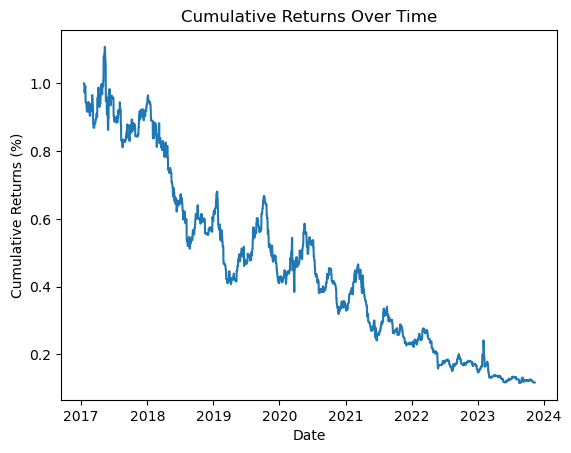

In [12]:

returns_df = pd.DataFrame()

for pair in correlation_pairs:
    results = stat_arbit(pair, start, end, interval='1d', sl = 0.03, tp = 0.06)
    plot = results.plot()
    cum_returns = results.cum_returns()  # Assuming `cum_returns()` is a method that calculates cumulative returns
    
    returns_df[pair] = cum_returns

returns_df.index.name = 'Date'  # Set the index name to 'Pair'
returns_df.to_csv('pair_cum_returns.csv')  # Save DataFrame to CSV without the index label


In [13]:
# In[166]:


portfolio_returns = pd.read_csv("C:\\Users\\Sony\\pair_cum_returns.csv", parse_dates=True)
portfolio_returns.set_index('Date', inplace=True)
portfolio_returns.index = pd.to_datetime(portfolio_returns.index)
portfolio_returns.fillna(method='ffill', inplace=True)
# Replace remaining NaN values with 0
portfolio_returns.fillna(0, inplace=True)
portfolio_returns['strategy_returns'] = portfolio_returns.iloc[:, 1:].sum(axis=1).values
portfolio_returns.to_csv("new_port.csv")


<AxesSubplot:xlabel='Date'>

Stat_arbit returns: 114.8


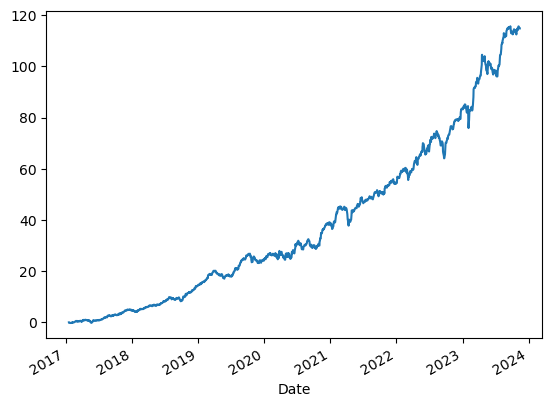

In [14]:
# Plot non-zero and non-NaN returns
portfolio_returns['strategy_returns'] = portfolio_returns['strategy_returns'].replace(0, np.nan).dropna()
portfolio_returns['strategy_returns'].plot()

# Calculate last cumulative sum
last_cumsum = portfolio_returns['strategy_returns'].iloc[-1]
print("Stat_arbit returns:", np.round(last_cumsum, 2))

In [15]:
def analysis(strategy_returns, risk_free_rate):
    # Calculate daily returns
    returns = strategy_returns.pct_change()

    # Calculate annualized mean return and standard deviation
    annualized_mean_return = returns.mean() * 252
    annualized_std_dev = returns.std() * np.sqrt(252)

    # Calculate Sharpe ratio
    sharpe_ratio = (annualized_mean_return - risk_free_rate) / annualized_std_dev

    # Calculate drawdown (DD)
    previous_peaks = strategy_returns.cummax()
    drawdown = strategy_returns - previous_peaks
    max_drawdown = drawdown.min()

    # Calculate Sortino ratio
    downside_returns = returns[returns < 0]
    downside_std_dev = downside_returns.std() * np.sqrt(252)
    sortino_ratio = (annualized_mean_return - risk_free_rate) / downside_std_dev

    print("sharpe ratio:",sharpe_ratio)
    print("max_dd:",max_drawdown)
    print("sortino ratio:",sortino_ratio)

In [16]:
risk_free_rate = 0.02

In [17]:
strategy_returns = portfolio_returns['strategy_returns']

In [18]:
final_out = analysis(strategy_returns, risk_free_rate)

sharpe ratio: 0.009961881779302321
max_dd: -10.64734981916645
sortino ratio: 0.008253992856398874


In [ ]:
import numpy as np
import pandas as pd
from hrpy import hierarchical_clustering, hrp

# Sample data (replace with your own)
returns_data = pd.DataFrame({
    'Asset1': np.random.rand(100),
    'Asset2': np.random.rand(100),
    'Asset3': np.random.rand(100),
    # Add more assets as needed
})

# Hierarchical clustering
linkage_matrix = hierarchical_clustering(returns_data.corr())

# Hierarchical Risk Parity
weights = hrp(linkage_matrix)

# Display weights
print("Asset Weights:")
print(weights)